In [4]:
import tensorflow as tf
import numpy as np

def weights_diff(model1, model2):
    model_diff = []
    layer_sizes = []
    for i in range(len(model1.layers)):
      if len(model1.layers[i].get_weights()) > 0:
#         print("Layer " + str(i + 1) + ":")
        layer_diff = model1.layers[i].get_weights()[0] - model2.layers[i].get_weights()[0]
        model_diff.append(layer_diff)
#         print(layer_diff)
    for i in range(len(model_diff)):
      current_layer_size = 0
      total_nonzero = 0
      max = 0
      for cell in np.nditer(model_diff[i]):
        current_layer_size += 1
        if abs(cell) > 0.01:
          total_nonzero += 1
          if abs(cell) > max:
            max = cell
      percentage_diff = ((total_nonzero * 1.) / current_layer_size) * 100
      print("Amount of different weights in Layer " + str(i + 1) + ": " + str(total_nonzero)
            + " / " + str(current_layer_size) + " (" + str(percentage_diff) + "%)")
      print("Maximum Difference in Layer " + str(i+1) + ": " + str(max))
      layer_sizes.append(current_layer_size)

In [5]:
import os
os.getcwd()

'/home/jovyan/work/drift/Data Drift'

In [6]:
m1 = tf.keras.models.load_model('based_model') # Model trained on all mnist data
m2 = tf.keras.models.load_model('sudden_drift_30000') # m1 trained with first 30000 mnist data with random noise
m3 = tf.keras.models.load_model('new_trained') # Model trained with all mnist data and first 30000 mnist data with random noise

weights_diff(m1, m2)
print("----------------------------------")
weights_diff(m2, m3)
print("----------------------------------")
weights_diff(m3, m1)

Amount of different weights in Layer 1: 133 / 288 (46.18055555555556%)
Maximum Difference in Layer 1: 0.031100687
Amount of different weights in Layer 2: 17 / 32 (53.125%)
Maximum Difference in Layer 2: 0.034783542
Amount of different weights in Layer 3: 3541 / 9216 (38.42230902777778%)
Maximum Difference in Layer 3: 0.040661
Amount of different weights in Layer 4: 16 / 32 (50.0%)
Maximum Difference in Layer 4: 0.022628129
Amount of different weights in Layer 5: 7304 / 25600 (28.531250000000004%)
Maximum Difference in Layer 5: 0.039933342
Amount of different weights in Layer 6: 12 / 32 (37.5%)
Maximum Difference in Layer 6: -0.018496633
Amount of different weights in Layer 7: 5560 / 18432 (30.164930555555557%)
Maximum Difference in Layer 7: 0.03925994
Amount of different weights in Layer 8: 16 / 64 (25.0%)
Maximum Difference in Layer 8: 0.01779306
Amount of different weights in Layer 9: 7281 / 36864 (19.7509765625%)
Maximum Difference in Layer 9: 0.039166067
Amount of different weights

In [7]:
k1 = tf.keras.models.load_model('half_normal') # Model trained on first 30000 mnist data
k2 = tf.keras.models.load_model('half_normal_added_10k_mix') # m1 trained with mnist data [30000:35000] + noise(mnist data[:5000])

weights_diff(k1, k2)

Amount of different weights in Layer 1: 70 / 288 (24.305555555555554%)
Maximum Difference in Layer 1: 0.012422748
Amount of different weights in Layer 2: 9 / 32 (28.125%)
Maximum Difference in Layer 2: 0.021133542
Amount of different weights in Layer 3: 1149 / 9216 (12.467447916666668%)
Maximum Difference in Layer 3: 0.011451639
Amount of different weights in Layer 4: 5 / 32 (15.625%)
Maximum Difference in Layer 4: 0.015349984
Amount of different weights in Layer 5: 1623 / 25600 (6.33984375%)
Maximum Difference in Layer 5: 0.021831749
Amount of different weights in Layer 6: 5 / 32 (15.625%)
Maximum Difference in Layer 6: 0.0151234865
Amount of different weights in Layer 7: 970 / 18432 (5.262586805555555%)
Maximum Difference in Layer 7: 0.02005937
Amount of different weights in Layer 8: 4 / 64 (6.25%)
Maximum Difference in Layer 8: 0.013016164
Amount of different weights in Layer 9: 1010 / 36864 (2.7398003472222223%)
Maximum Difference in Layer 9: 0.023332352
Amount of different weights

In [9]:
m1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 12, 12, 32)       

In [10]:
# Visualizing difference between k1 and k2 layer with 204800 params

k1 = tf.keras.models.load_model('half_normal') # Model trained on first 30000 mnist data
k2 = tf.keras.models.load_model('half_normal_added_10k_mix') # m1 trained with mnist data [30000:35000] + noise(mnist data[:5000])

w1 = k1.layers[15].get_weights()[0].reshape(-1,128)
w2 = k2.layers[15].get_weights()[0].reshape(-1,128)

In [11]:
import numpy as np

diff = np.abs(w1-w2)

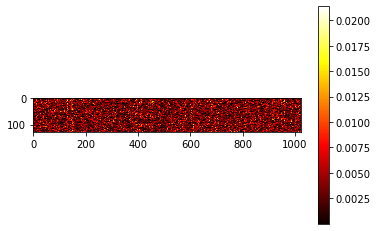

In [12]:
import matplotlib.pyplot as plt

plt.imshow(diff.T, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()